In [61]:
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,roc_auc_score,accuracy_score,recall_score,precision_score,average_precision_score,log_loss
from sklearn.metrics import f1_score,max_error,confusion_matrix,RocCurveDisplay,balanced_accuracy_score,PrecisionRecallDisplay,precision_recall_curve
import numpy as np
import glob
from scipy.stats import ttest_ind,binom_test
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
def highlight_max(x):
    return ['font-weight: bold' if v == x.loc[4] else ''
                for v in x]

In [3]:
target_cols=['label_mean','HD', 'CV', 'VO','REL', 'RAE', 'SXO', 'GEN', 'IDL', 'NAT', 'POL', 'MPH', 'EX', 'IM']

In [69]:
def get_ensemble_score(pkl,ensemble_name):
    group = {}
    type_mode = {}
    Score_auc = {}
    Score_acc = {}
    Names = {}
    fig, ax = plt.subplots(figsize=(15, 8))
    for t in target_cols:
        group[t] = []
        Score_auc[t] = []
        Score_acc[t] = []
        Names[t] = []
        type_mode[t] = []
    for p in pkl:
        if "small" in p:
            n = "small"
        elif "large" in p:
            n = "large"
        else:
            n = "base"
        tta = None if "tta" not in p else "tta"
        name=p.split("/")[0] + "_" + n
        if tta:
            name = name + "_" + tta
        name = name.replace("_cla","")
        df=pd.read_pickle(p)
        AUC,ACC,Group = [],[],[]
        
        for col in target_cols:
            Names[col].append(name)
            type_mode[col].append(n)
            acc_best = 0
            best_f1 = 0
            for tt in range(0,100,5):
                auc,acc = roc_auc_score(df[col],df[f'pred_{col}'])*100,f1_score(df[col],df[f'pred_{col}']>(tt/100),average='weighted')
                if acc_best < acc:
                    acc_best = acc
                    best_f1 = tt/100
            acc = acc_best
            Score_auc[col].append(auc)
            Score_acc[col].append(acc)
            group[col].append(df[f'pred_{col}'].tolist())
            if col == 'label_mean':
                RocCurveDisplay.from_predictions(
                                df[col],
                                df[f'pred_{col}'],
                                name=f"{name}",ax=ax
                            )
    if ensemble_name is not None:
        fig, ax = plt.subplots(figsize=(15, 6))
        for col in target_cols:
            
                
            pred = np.array(group[col]).mean(0)
            acc_best = 0
            for tt in range(0,100,5):
                auc,acc = roc_auc_score(df[col],pred)*100,f1_score(df[col],pred>(tt/100),average='weighted')
                if acc_best < acc:
                    acc_best = acc
            acc = acc_best
            Score_auc[col].append(auc)
            Score_acc[col].append(acc)
            Names[col].append(ensemble_name)
            if col == 'label_mean':
                name = 'Hate' 
            else: 
                name=col
                RocCurveDisplay.from_predictions(
                            df[col],
                            pred,
                            name=f"{name}",ax=ax
                        )
    df_auc = pd.DataFrame.from_dict(Score_auc).T
    df_auc.columns = Names['label_mean']
    df_auc = df_auc.T
    df_auc['mean'] = df_auc.mean(axis=1)
    
    df_acc = pd.DataFrame.from_dict(Score_acc).T
    df_acc.columns = Names['label_mean']
    df_acc = df_acc.T
    df_acc['mean'] = df_acc.mean(axis=1)

    return type_mode,Names,Score_auc,Score_acc,group,df_auc.rename({"label_mean":"Hate"},axis=1),df_acc.rename({"label_mean":"Hate"},axis=1)

In [70]:
# PrecisionRecallDisplay.from_predictions?

# baseline ensemble

,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM,mean
Gab_baseline_small,79.610363,79.743731,74.284754,82.643994,85.121697,89.318247,88.332358,82.909020,78.880082,75.951067,76.833280,74.271382,82.243107,72.129614,80.162336
Gab_baseline_base,81.509907,81.159556,78.369162,83.423574,86.800773,87.846215,87.843322,78.993451,79.189112,74.236781,76.204341,75.733123,84.186650,73.354509,80.632177
Gab_baseline_large,80.942585,80.967474,76.675520,83.077941,87.622653,89.135466,89.825059,81.384256,79.355423,75.462863,76.247578,77.409063,83.444884,73.175032,81.051843
Gab_backtranslate_small,80.625763,80.598639,78.741540,82.769946,86.526254,89.382356,89.381187,84.896297,79.881732,77.380619,78.054377,77.659475,82.881750,73.044467,81.558886
Gab_backtranslate_small_tta,80.742969,80.709401,78.882102,82.789402,87.220526,89.621503,89.716342,85.083940,80.173429,77.509426,78.306801,77.295431,82.932274,73.228964,81.729465
Gab_backtranslate_base,81.931279,81.937521,77.385366,82.930413,86.425276,89.318557,89.500727,81.484714,80.326376,76.948127,78.594077,77.888385,83.953349,74.051481,81.619689
Gab_backtranslate_base_tta,82.086037,82.102379,77.696250,82.954849,86.799393,89.556910,90.021358,81.818329,80.396177,77.137595,78.965777,77.830358,84.005211,74.307061,81.834120
Gab_backtranslate_large,80.338645,80.485685,77.749105,82.526117,89.065116,90.328135,88.852189,81.822440,80.156826,75.736708,75.529208,78.712441,83.315173,72.663007,81.234342
Gab_backtranslate_large_tta,80.108152,80.287362,77.619942,82.330174,89.252701,90.471853,88.943063,81.738936,80.077396,75.518437,75.387881,78.410956,83.060049,72.585453,81.128025
ensemble_all,82.593713,82.623147,79.943426,84.539323,89.241833,91.076545,91.026550,85.662506,82.316310,77.923289,79.676996,80.070199,85.038819,74.712984,83.317546


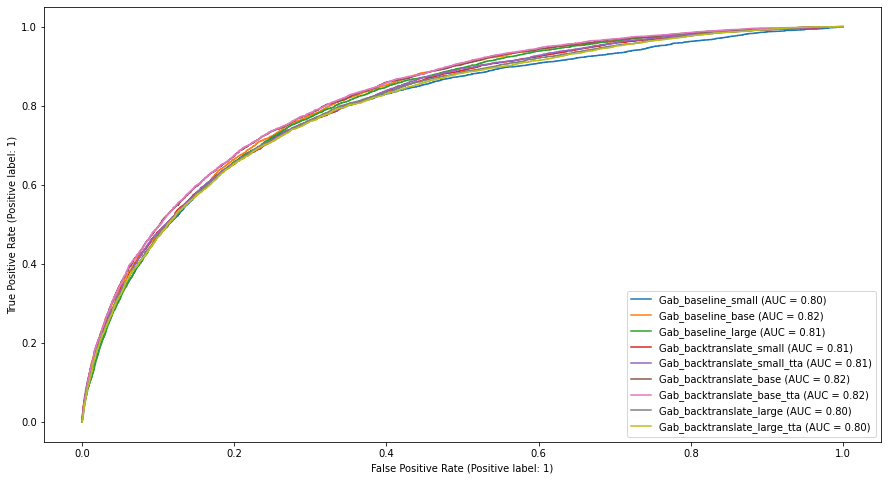

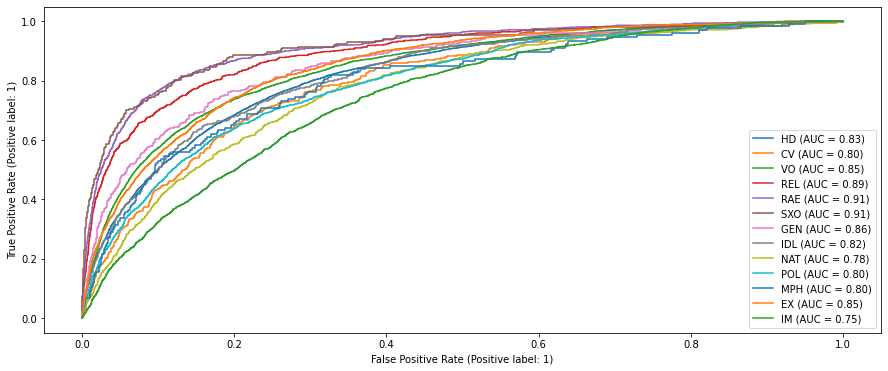

In [71]:
pkl = [row for row in glob.glob("Gab_*_cla/*/*.pkl") if "_cla" in row]
type_mode,Names,Score_auc,Score_acc,group,df_auc,df_acc = get_ensemble_score(pkl,ensemble_name='ensemble_all')
df_auc.style.set_caption('roc_auc_score').highlight_max(color = 'lightgreen', axis = 0)

In [73]:
df_acc.style.set_caption('weighted F1 score').highlight_max(color = 'lightgreen', axis = 0)

,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM,mean
Gab_baseline_small,0.844479,0.850643,0.982504,0.883559,0.964828,0.961163,0.990261,0.984501,0.972480,0.964916,0.938724,0.992711,0.902513,0.915098,0.939170
Gab_baseline_base,0.848294,0.853039,0.982504,0.885763,0.963554,0.959450,0.989869,0.984240,0.971835,0.964916,0.937589,0.992711,0.908213,0.915158,0.939795
Gab_baseline_large,0.843828,0.849020,0.982504,0.880578,0.965665,0.958286,0.990453,0.984320,0.973115,0.964991,0.938291,0.992711,0.903987,0.915469,0.938801
Gab_backtranslate_small,0.847204,0.852873,0.982504,0.881971,0.967116,0.963059,0.989466,0.984771,0.971981,0.964916,0.938958,0.992711,0.904919,0.915759,0.939872
Gab_backtranslate_small_tta,0.846337,0.852680,0.982504,0.882084,0.967414,0.963030,0.989474,0.984709,0.971877,0.964916,0.938887,0.992711,0.905268,0.915691,0.939827
Gab_backtranslate_base,0.850199,0.855043,0.982504,0.883758,0.966146,0.962466,0.990136,0.984240,0.972000,0.965016,0.939353,0.992711,0.906523,0.914841,0.940353
Gab_backtranslate_base_tta,0.851488,0.855835,0.982504,0.882797,0.966002,0.962159,0.990170,0.984264,0.972007,0.965039,0.939584,0.992711,0.906438,0.914705,0.940407
Gab_backtranslate_large,0.845898,0.850575,0.982504,0.882826,0.966031,0.959983,0.990096,0.984630,0.972681,0.965066,0.937588,0.992711,0.904781,0.914637,0.939286
Gab_backtranslate_large_tta,0.845307,0.851251,0.982504,0.882091,0.966138,0.959404,0.989818,0.984613,0.972442,0.965109,0.937604,0.992711,0.904472,0.914744,0.939158
ensemble_all,0.851982,0.857263,0.982504,0.887330,0.968468,0.963468,0.990717,0.984585,0.972686,0.965201,0.940371,0.992711,0.909352,0.915128,0.941555


,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM,mean
Gab_baseline_base,0.848294,0.853039,0.982504,0.885763,0.963554,0.959450,0.989869,0.984240,0.971835,0.964916,0.937589,0.992711,0.908213,0.915158,0.939795
Gab_backtranslate_base,0.850199,0.855043,0.982504,0.883758,0.966146,0.962466,0.990136,0.984240,0.972000,0.965016,0.939353,0.992711,0.906523,0.914841,0.940353
Gab_backtranslate_base_tta,0.851488,0.855835,0.982504,0.882797,0.966002,0.962159,0.990170,0.984264,0.972007,0.965039,0.939584,0.992711,0.906438,0.914705,0.940407


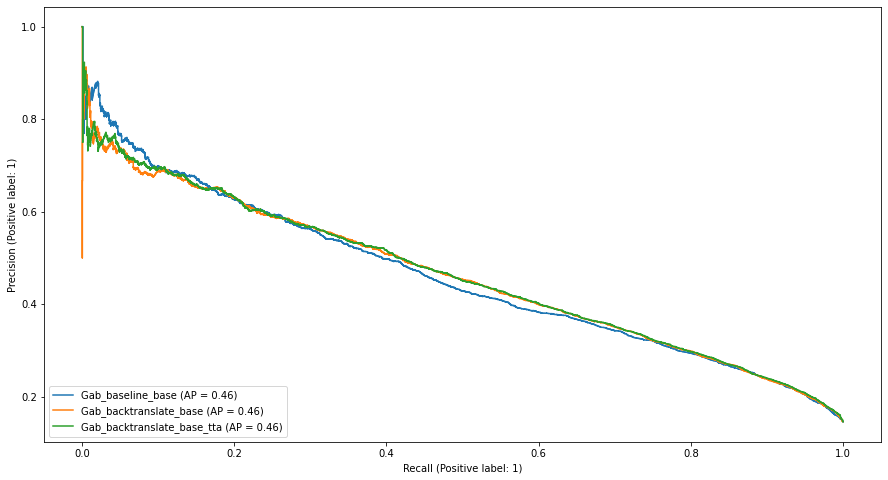

In [56]:
pkl = [row for row in glob.glob("Gab_*_cla/*base*/*.pkl") if "_cla" in row]
type_mode,Names,Score_auc,Score_acc,group,df_auc,df_acc = get_ensemble_score(pkl,ensemble_name=None)
df_acc.style.set_caption('F1 score').highlight_max(color = 'lightgreen', axis = 0)

In [14]:
df_auc.style.set_caption('roc_auc_score').highlight_max(color = 'lightgreen', axis = 0)

,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM,mean
Gab_baseline_base,81.509907,81.159556,78.369162,83.423574,86.800773,87.846215,87.843322,78.993451,79.189112,74.236781,76.204341,75.733123,84.186650,73.354509,80.632177
Gab_backtranslate_base,81.931279,81.937521,77.385366,82.930413,86.425276,89.318557,89.500727,81.484714,80.326376,76.948127,78.594077,77.888385,83.953349,74.051481,81.619689
Gab_backtranslate_base_tta,82.086037,82.102379,77.696250,82.954849,86.799393,89.556910,90.021358,81.818329,80.396177,77.137595,78.965777,77.830358,84.005211,74.307061,81.834120


,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM,mean
Gab_baseline_small,79.610363,79.743731,74.284754,82.643994,85.121697,89.318247,88.332358,82.909020,78.880082,75.951067,76.833280,74.271382,82.243107,72.129614,80.162336
Gab_backtranslate_small,80.625763,80.598639,78.741540,82.769946,86.526254,89.382356,89.381187,84.896297,79.881732,77.380619,78.054377,77.659475,82.881750,73.044467,81.558886
Gab_backtranslate_small_tta,80.742969,80.709401,78.882102,82.789402,87.220526,89.621503,89.716342,85.083940,80.173429,77.509426,78.306801,77.295431,82.932274,73.228964,81.729465


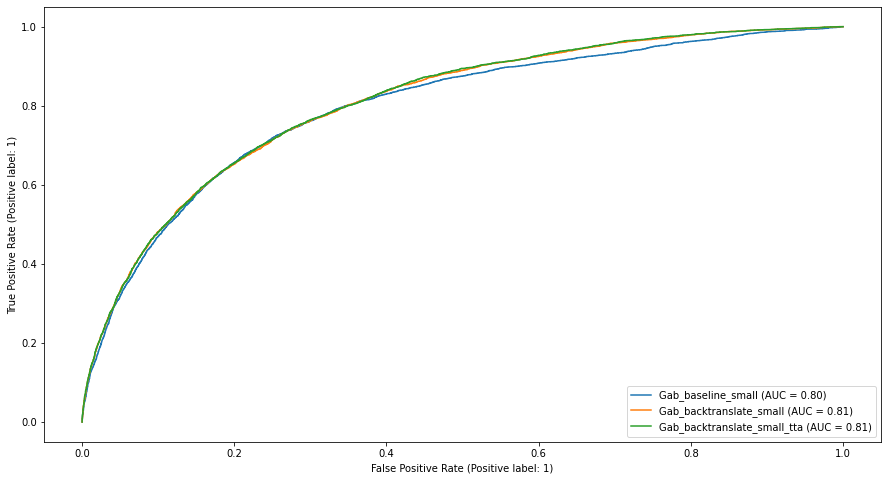

In [15]:
pkl = [row for row in glob.glob("Gab_*_cla/*small*/*.pkl") if "_cla" in row]
type_mode,Names,Score_auc,Score_acc,group,df_auc,df_acc = get_ensemble_score(pkl,ensemble_name=None)
df_auc.style.set_caption('roc_auc_score').highlight_max(color = 'lightgreen', axis = 0)

,Hate,HD,CV,VO,REL,RAE,SXO,GEN,IDL,NAT,POL,MPH,EX,IM,mean
Gab_baseline_large,80.942585,80.967474,76.675520,83.077941,87.622653,89.135466,89.825059,81.384256,79.355423,75.462863,76.247578,77.409063,83.444884,73.175032,81.051843
Gab_backtranslate_large,80.338645,80.485685,77.749105,82.526117,89.065116,90.328135,88.852189,81.822440,80.156826,75.736708,75.529208,78.712441,83.315173,72.663007,81.234342
Gab_backtranslate_large_tta,80.108152,80.287362,77.619942,82.330174,89.252701,90.471853,88.943063,81.738936,80.077396,75.518437,75.387881,78.410956,83.060049,72.585453,81.128025


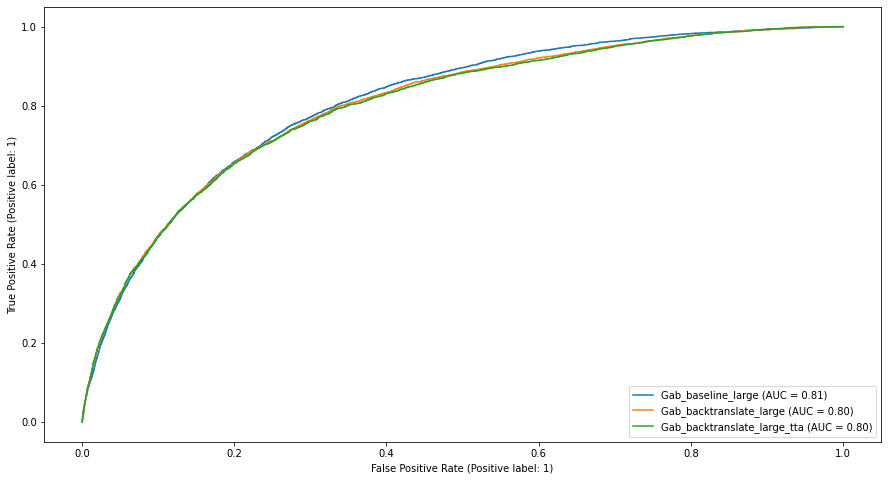

In [16]:
pkl = [row for row in glob.glob("Gab_*_cla/*large*/*.pkl") if "_cla" in row]
type_mode,Names,Score_auc,Score_acc,group,df_auc,df_acc = get_ensemble_score(pkl,ensemble_name=None)
df_auc.style.set_caption('roc_auc_score').highlight_max(color = 'lightgreen', axis = 0)